In [42]:
import os
import zipfile
import pandas as pd
import numpy as np
import pydotplus
import matplotlib.pyplot as plt
from sklearn import metrics
from skimage import io
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import export_graphviz
from sklearn import tree 
from IPython.display import Image  
from six import StringIO
from sklearn.metrics import confusion_matrix, classification_report, RocCurveDisplay
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

%matplotlib inline

In [43]:
DIRECT = os.getcwd()

# Store your training zip folder in the lauched jupyter notebook's folder.
def fetch_data(zip_path, new = DIRECT):
    PATH = os.path.join(DIRECT, zip_path)
    with zipfile.ZipFile(PATH, 'r') as temp:
        temp.extractall(new)
        
# Method to load cvs data and display it with the pandas library.
def load_data(file_path, root_path = DIRECT):
    cvs_path = os.path.join(root_path, file_path)
    return pd.read_csv(cvs_path)

fetch_data("archive.zip")
data = load_data("Weather Training Data.csv")

print(data.head())
print("Total number of entries:",len(data))
print("Total number of attribues:", len(data.columns))

  row ID Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0   Row0   Albury     13.4     22.9       0.6          NaN       NaN   
1   Row1   Albury      7.4     25.1       0.0          NaN       NaN   
2   Row2   Albury     17.5     32.3       1.0          NaN       NaN   
3   Row3   Albury     14.6     29.7       0.2          NaN       NaN   
4   Row4   Albury      7.7     26.7       0.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  Humidity3pm  \
0           W           44.0          W  ...        71.0         22.0   
1         WNW           44.0        NNW  ...        44.0         25.0   
2           W           41.0        ENE  ...        82.0         33.0   
3         WNW           56.0          W  ...        55.0         23.0   
4           W           35.0        SSE  ...        48.0         19.0   

   Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  \
0       1007.7       1007.1       8.0       NaN 

In [44]:
# Copy our data and drop any unneccesary attributes for features. Store in a separate dataframe.
copy_data = data.copy()
features = copy_data.drop("row ID", axis=1).drop("Location", axis=1).drop("RainTomorrow", axis=1)
features = pd.DataFrame(features)

print(features.head())
print("Total number of entries:",len(features))
print("Total number of attribues:", len(features.columns))

   MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine WindGustDir  \
0     13.4     22.9       0.6          NaN       NaN           W   
1      7.4     25.1       0.0          NaN       NaN         WNW   
2     17.5     32.3       1.0          NaN       NaN           W   
3     14.6     29.7       0.2          NaN       NaN         WNW   
4      7.7     26.7       0.0          NaN       NaN           W   

   WindGustSpeed WindDir9am WindDir3pm  WindSpeed9am  WindSpeed3pm  \
0           44.0          W        WNW          20.0          24.0   
1           44.0        NNW        WSW           4.0          22.0   
2           41.0        ENE         NW           7.0          20.0   
3           56.0          W          W          19.0          24.0   
4           35.0        SSE          W           6.0          17.0   

   Humidity9am  Humidity3pm  Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  \
0         71.0         22.0       1007.7       1007.1       8.0       NaN   
1         44.0  

In [45]:
list_of_feature_names = [features.columns[x] for x in range(len(features.columns))]
print(list_of_feature_names)

['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday']


In [46]:
# Preprocess the features with LabelEncoder() for the features dataframe.
def preprocess_features_column(col):
    temp = features[col]
    le = preprocessing.LabelEncoder()
    le.fit(temp)
    new = le.transform(temp)
    return new

# List of attributes that need to be converted to int values.
list_of_col = ["WindGustDir", "WindDir9am", "WindDir3pm", "RainToday"]

# For every index in list_of_col, pass through the preprocess_features_column function.
for x in range(len(list_of_col)):
    col = preprocess_features_column(list_of_col[x])
    features[list_of_col[x]] = pd.DataFrame(col)

print(features.head())
print("Total number of entries:",len(features))
print("Total number of attribues:", len(features.columns))

   MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  WindGustDir  \
0     13.4     22.9       0.6          NaN       NaN           13   
1      7.4     25.1       0.0          NaN       NaN           14   
2     17.5     32.3       1.0          NaN       NaN           13   
3     14.6     29.7       0.2          NaN       NaN           14   
4      7.7     26.7       0.0          NaN       NaN           13   

   WindGustSpeed  WindDir9am  WindDir3pm  WindSpeed9am  WindSpeed3pm  \
0           44.0          13          14          20.0          24.0   
1           44.0           6          15           4.0          22.0   
2           41.0           1           7           7.0          20.0   
3           56.0          13          13          19.0          24.0   
4           35.0          10          13           6.0          17.0   

   Humidity9am  Humidity3pm  Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  \
0         71.0         22.0       1007.7       1007.1       8.0       NaN  

In [47]:
# Rescale everything to be between 0 and 1.
scaler = MinMaxScaler()
temp = pd.DataFrame(scaler.fit_transform(features))

# If a value is nan, set it to 0.
for x in range(len(temp)):
    for y in range(len(temp.columns)):
        if not(temp[y][x] > 0):
            temp[y][x] = 0

            
features = temp.copy() # Copy new dataframe.

print(features.head())
print("Total number of entries:",len(features))
print("Total number of attribues:", len(features.columns))

         0         1         2    3    4       5         6       7       8   \
0  0.516509  0.517241  0.001617  0.0  0.0  0.8125  0.294574  0.8125  0.8750   
1  0.375000  0.559387  0.000000  0.0  0.0  0.8750  0.294574  0.3750  0.9375   
2  0.613208  0.697318  0.002695  0.0  0.0  0.8125  0.271318  0.0625  0.4375   
3  0.544811  0.647510  0.000539  0.0  0.0  0.8750  0.387597  0.8125  0.8125   
4  0.382075  0.590038  0.000000  0.0  0.0  0.8125  0.224806  0.6250  0.8125   

         9         10    11    12        13        14        15        16  \
0  0.153846  0.275862  0.71  0.22  0.449587  0.470684  0.888889  0.000000   
1  0.030769  0.252874  0.44  0.25  0.497521  0.482085  0.000000  0.000000   
2  0.053846  0.229885  0.82  0.33  0.500826  0.452769  0.777778  0.888889   
3  0.146154  0.275862  0.55  0.23  0.474380  0.442997  0.000000  0.000000   
4  0.046154  0.195402  0.48  0.19  0.543802  0.519544  0.000000  0.000000   

         17        18   19  
0  0.506356  0.519305  0.0  
1  0

In [48]:
# Separate the labels data from the copy_data. Store in a separate dataframe.
labels = copy_data["RainTomorrow"]
labels = pd.DataFrame(labels)

print(labels.head())
print("Total number of entries:",len(labels))
print("Total number of attribues:", len(labels.columns))

   RainTomorrow
0             0
1             0
2             0
3             0
4             0
Total number of entries: 99516
Total number of attribues: 1


In [49]:
list_of_class_names = [labels.columns[x] for x in range(len(labels.columns))]
print(list_of_class_names)

['RainTomorrow']


In [50]:
# Stratified splitting the features and labels data into a training and testing.
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=20)
for train_index, test_index in split.split(features, labels):
    X_train_full, y_train_full = features.loc[train_index], labels.loc[train_index]
    X_test, y_test = features.loc[test_index], labels.loc[test_index]
    
print("Total number of entries in X_train_full:", len(X_train_full))
print("Total number of entries in y_train_full:", len(y_train_full))
print("Total number of entries in X_test:", len(X_test))
print("Total number of entries in y_test:", len(y_test))

Total number of entries in X_train_full: 79612
Total number of entries in y_train_full: 79612
Total number of entries in X_test: 19904
Total number of entries in y_test: 19904


In [51]:
# Separate 80% of the train_full datasets for training ([0%, 80%]) and 20% for validation ([80%, 100%]).
X_train, X_valid = X_train_full[:int(len(X_train_full)*.8)], X_train_full[int(len(X_train_full)*.8):]
y_train, y_valid = y_train_full[:int(len(y_train_full)*.8)], y_train_full[int(len(y_train_full)*.8):]

print("Total number of entries in X_train:", len(X_train))
print("Total number of entries in X_valid:", len(X_valid))
print("Total number of entries in y_train:", len(y_train))
print("Total number of entries in y_valid:", len(y_valid))

Total number of entries in X_train: 63689
Total number of entries in X_valid: 15923
Total number of entries in y_train: 63689
Total number of entries in y_valid: 15923


In [52]:
# Train a Decision Tree w/ a set max_depth w/ the fitted datasets, Training.
tree_clf = DecisionTreeClassifier(max_depth=4)
tree_clf.fit(X_train, y_train)

# Accuracy evalution.
y_pred = tree_clf.predict(X_test)
print("Training Accuracy:", accuracy_score(y_test, y_pred))

Training Accuracy: 0.8326969453376206


[[14567   865]
 [ 2465  2007]]


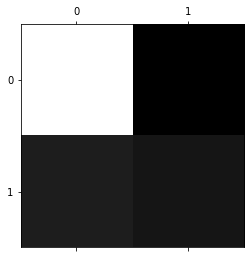

In [53]:
# Create and display the confusion matrix for the Training datasets.
conf_mx = confusion_matrix(y_test, y_pred)
print(conf_mx)

plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

Precision: 0.699
Recall: 0.449
F-Score: 0.547


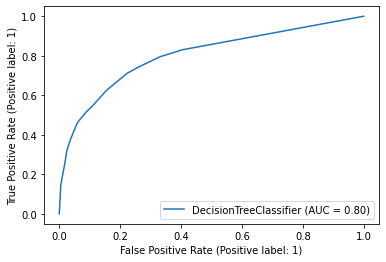

In [54]:
roc_train = RocCurveDisplay.from_estimator(tree_clf, X_test, y_test)
print('Precision: %.3f' % precision_score(y_test, y_pred))
print('Recall: %.3f' % recall_score(y_test, y_pred))
print('F-Score: %.3f' % f1_score(y_test, y_pred))

In [55]:
# Create and store a .dot file containing the entire decision tree generated for Training.
PATH = os.path.join(DIRECT, "training_tree.dot")

tree.export_graphviz(tree_clf, out_file=PATH, feature_names=list_of_feature_names)

In [56]:
# Train a Decision Tree w/ a set max_depth w/ the fitted datasets, Training.
tree_clf = DecisionTreeClassifier(max_depth=4)
tree_clf.fit(X_valid, y_valid)

y_pred = tree_clf.predict(X_test)
print("Validation Accuracy:", accuracy_score(y_test, y_pred))

Validation Accuracy: 0.828878617363344


[[14359  1073]
 [ 2333  2139]]


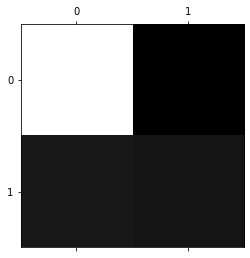

In [57]:
# Create and display the confusion matrix for the Validation datasets.
conf_mx = confusion_matrix(y_test, y_pred)
print(conf_mx)

plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

Precision: 0.666
Recall: 0.478
F-Score: 0.557


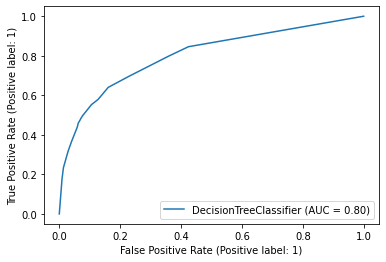

In [58]:
roc_train = RocCurveDisplay.from_estimator(tree_clf, X_test, y_test)
print('Precision: %.3f' % precision_score(y_test, y_pred))
print('Recall: %.3f' % recall_score(y_test, y_pred))
print('F-Score: %.3f' % f1_score(y_test, y_pred))

In [59]:
# Create and store a .dot file containing the entire decision tree generated for Validation.
PATH = os.path.join(DIRECT, "validation_tree.dot")

tree.export_graphviz(tree_clf, out_file=PATH, feature_names=list_of_feature_names)